In [126]:

# !/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import time
from nolds.measures import poly_fit
from nolitsa import data, lyapunov
from nolitsa.d2 import *
import numpy as np
import matplotlib.pyplot as plt
from RBFNN import *
from dataset.chaotic_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from utils import *

class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


path = 'result/attractor_reconstruction'
if not os.path.exists(path):
    os.makedirs(path)
    

names = [
    'rossler',
    'rabinovich_fabrikant',
    'lorentz',
    'chua',
]
names = [n + '1d' for n in names]


n_dim = 1
horizon = 1
N = 10000
n_history = 10  # 使用 n 个历史点作为输入
N_h = 200
num_prepare = 10
num_train = 2000
num_test = 2000
train_start = 0
test_start = 5000
np.random.seed()
nz = 100
reservoirConf = Dict(
    alpha=0.9,
    connectivity= 1,
    nz= nz,
    nu = n_dim,
    target_rho=0.99,
    input_scale= 1,
#     activation = lambda x: 1/(1 + np.exp(-x))  # sigmoid
#     activation = lambda x: np.maximum(0,x)
#     activation = lambda x: x/(1 + np.exp(-x))
    activation = np.tanh
#     activation = lambda x: np.sin(x)
)

def is_valid(y):
    y = np.squeeze(y)
    if np.sum(np.isnan(y)) > 0:
        return False
    if np.max(y) > 1.1 or np.min(y) < -0.1 or np.max(y)-np.min(y) < 0.8:
        return False
    if np.std(y[-500:]) < 1e-4:
        return False
    print(np.std(y[-500:]))
    return True

def gen_model(conf):
    _, model_type, kwargs = conf
    conf_dict = dict(
        model_type=model_type,
        **kwargs
    )
    return RBFNN(**conf_dict)


def select_model(model_confs):
    MSE = [0.0] * len(model_confs)
    for j, conf in enumerate(model_confs):
        model = gen_model(conf)
        model.train(x_train, y_train, num_prepare)
        Predictions = model.predict(x_test, num_prepare)
        MSE[j] = mse(Predictions, y_test)
    best_model = model_confs[np.argmin(MSE)]
    return best_model

for file in range(50):
    result_file = path + '/result_'+str(file) + '.csv'
    if os.path.exists(result_file):
        result = pd.read_csv(result_file)
    else:
        result = pd.DataFrame(columns=['datetime', 
                                       'system_name',  
                                       'n_dim', 
                                       'n_history', 
                                       'num_prepare',
                                       'nz',
                                       'model_name', 
                                       'valid'])

    process_start_time = time.time()
    print('开始数据处理')
    for system_name in names:
        for num_prepare in [100]:
            for n_history in [20]:
                x = np.loadtxt('dataset/'+system_name+'.txt', delimiter=',').T
                x += np.random.randn(*x.shape)*0.001

                x_train = np.vstack([select_samples(x, train_start + i, num_train + num_prepare) for i in range(n_history)])
                x_test = np.vstack([select_samples(x, test_start + i, num_test + num_prepare) for i in range(n_history)])
                y_test = select_samples(x, test_start + num_prepare + n_history, num_test)
                y_train = select_samples(x, train_start + num_prepare + n_history, num_train)


                model_confs = []

#                 model_confs.append(
#                     [('VAR', 
#                     ModelType.VAR, 
#                     dict())]
#                 )

                model_confs.append(
                    [('ESN-transform', 
                    ModelType.ESN, 
                    dict(reservoirConf=reservoirConf,encoder='transform',skip_con=1))]
                )

#                 model_confs.append(
#                     [('ESN-echostate', 
#                     ModelType.ESN, 
#                     dict(reservoirConf=reservoirConf,encoder='echostate',skip_con=1))]
#                 )

                model_confs.append(
                    [('RBFN-RE-transform', 
                    ModelType.RBFN_RE, 
                    dict(N_h=N_h, sigma=sigma, reservoirConf=reservoirConf, encoder='transform', skip_con=1)) 
                    for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
                )

#                 model_confs.append(
#                     [('RBFN-RE-echostate', 
#                     ModelType.RBFN_RE, 
#                     dict(N_h=N_h, sigma=sigma, reservoirConf=reservoirConf, encoder='echostate', skip_con=1)) 
#                     for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#                 )

                model_confs.append(
                    [('ESN-ATTN-transform',
                    ModelType.ESN_ATTN, 
                    dict(N_h=N_h, sigma=sigma, reservoirConf=reservoirConf,encoder='transform',skip_con=1))
                    for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
                )

#                 model_confs.append(
#                     [('ESN-ATTN-echostate',
#                     ModelType.ESN_ATTN, 
#                     dict(N_h=N_h, sigma=sigma, reservoirConf=reservoirConf,encoder='echostate',skip_con=1))
#                     for sigma in [ 1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#                 )


                for j, confs in enumerate(model_confs):

                    conf = select_model(confs)

                    model_name, model_type, kwargs = conf
                    print(model_name)

                    conf_dict = dict(
                        model_type=model_type,
                        **kwargs
                    )

                    model = RBFNN(**conf_dict)
                    model.train(x_train, y_train, num_prepare)

                    if 'encoder' in kwargs.keys() and  kwargs['encoder'] == 'echostate':
                        y_pred = model.predict_multistep_esn(x_test[:,:num_prepare+1], num_test)
                    else:
                        y_pred = model.predict_multistep(x_test[:, num_prepare:num_prepare+1], num_test)

                    y_pred = y_pred.reshape((num_test,n_dim)).T
                    
                    result.loc[result.shape[0]] = {
                        'datetime'          : pd.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                        'system_name'       : system_name,
                        'n_dim'             : n_dim,
                        'n_history'         : n_history,
                        'num_prepare'       : num_prepare,
                        'nz'                : nz,
                        'model_name'        : model_name,
                        'valid'             : is_valid(y_pred)
                    }
#                     print(result.loc[result.shape[0]-1])


#                     try:
#                         plt.figure(figsize=(20, 2))
#                         dim = ['x', 'y', 'z']
#                         for i in range(n_dim):
#                             plt.subplot(n_dim, 1, i + 1)
#                             plt.plot(y_test[i].T, color='black', label='ground truth')
#                             plt.plot(y_pred[i].T, color='red', label='generated track')
#                             plt.ylabel(dim[i])
#                             if i == 0:
#                                 plt.legend(loc='upper right')
#                         plt.xlabel('t')
#                         plt.show()
#                     except Exception as e:
#                         pass


    result.to_csv(result_file, index=False)

    print('结束数据处理')
    process_stop_time = time.time()

    # 差的时间戳
    diff_time = process_stop_time - process_start_time
    # 将计算出来的时间戳转换为结构化时间
    struct_time = time.gmtime(diff_time)
    # 减去时间戳最开始的时间 并格式化输出
    print('数据处理用了{0}年{1}月{2}日{3}小时{4}分钟{5}秒'.format(
        struct_time.tm_year - 1970,
        struct_time.tm_mon - 1,
        struct_time.tm_mday - 1,
        struct_time.tm_hour,
        struct_time.tm_min,
        struct_time.tm_sec
    ))



开始数据处理
ESN-transform
0.1945329123150383
RBFN-RE-transform
0.19122247164106748
ESN-ATTN-transform
0.22518239889871855
ESN-transform
0.2530332931595075
RBFN-RE-transform
0.24407487017564736
ESN-ATTN-transform
0.258054309721711
ESN-transform
RBFN-RE-transform
0.21035333798046701
ESN-ATTN-transform
0.2045170463968409
ESN-transform
RBFN-RE-transform
0.2775898236209894
ESN-ATTN-transform
结束数据处理
数据处理用了0年0月0日0小时2分钟35秒
开始数据处理
ESN-transform
RBFN-RE-transform
0.20909437281179163
ESN-ATTN-transform
0.18968050387351898
ESN-transform
0.2304769560948609
RBFN-RE-transform
0.22382168359524038
ESN-ATTN-transform
0.23018203289453862
ESN-transform
0.2089357427764946
RBFN-RE-transform
0.20876834558546536
ESN-ATTN-transform
0.18935151213442444
ESN-transform
RBFN-RE-transform
0.3163928193733199
ESN-ATTN-transform
结束数据处理
数据处理用了0年0月0日0小时2分钟36秒
开始数据处理
ESN-transform
0.21558265005698427
RBFN-RE-transform
0.21136832376399867
ESN-ATTN-transform
0.21695286495597368
ESN-transform
0.23423770944651126
RBFN-RE-transform

RBFN-RE-transform
0.21351046065757714
ESN-ATTN-transform
0.2087898390210913
ESN-transform
0.23292919932311223
RBFN-RE-transform
0.23518704306774438
ESN-ATTN-transform
0.21867725510045002
ESN-transform
0.20461048131017456
RBFN-RE-transform
0.211231123703961
ESN-ATTN-transform
0.003480700683596626
ESN-transform
RBFN-RE-transform
0.2883046890585261
ESN-ATTN-transform
结束数据处理
数据处理用了0年0月0日0小时2分钟32秒
开始数据处理
ESN-transform
0.21688848698158092
RBFN-RE-transform
0.2295785531324999
ESN-ATTN-transform
0.21660845812277832
ESN-transform
0.24115114009915214
RBFN-RE-transform
0.22827600442127938
ESN-ATTN-transform
0.23337873568162498
ESN-transform
0.20643904981386701
RBFN-RE-transform
ESN-ATTN-transform
0.20808469816137812
ESN-transform
RBFN-RE-transform
0.3560453413285566
ESN-ATTN-transform
0.0436753121119797
结束数据处理
数据处理用了0年0月0日0小时2分钟32秒
开始数据处理
ESN-transform
0.2196780550904623
RBFN-RE-transform
0.21356197336275817
ESN-ATTN-transform
0.20960154219305194
ESN-transform
0.24989450496367685
RBFN-RE-transfor

RBFN-RE-transform
0.21445652397586185
ESN-ATTN-transform
0.22914260264810873
ESN-transform
RBFN-RE-transform
ESN-ATTN-transform
ESN-transform
RBFN-RE-transform
0.21097437366973987
ESN-ATTN-transform
0.20653392090026207
ESN-transform
RBFN-RE-transform
0.2786859506571446
ESN-ATTN-transform
结束数据处理
数据处理用了0年0月0日0小时2分钟31秒
开始数据处理
ESN-transform
0.21288015745691757
RBFN-RE-transform
0.2235338429229433
ESN-ATTN-transform
ESN-transform
0.2432833258437398
RBFN-RE-transform
0.24307442396948617
ESN-ATTN-transform
0.21873736456557402
ESN-transform
0.20617021511148326
RBFN-RE-transform
0.21231461219957398
ESN-ATTN-transform
0.21153095357158636
ESN-transform
RBFN-RE-transform
0.27133947050023516
ESN-ATTN-transform
结束数据处理
数据处理用了0年0月0日0小时2分钟32秒
开始数据处理
ESN-transform
0.21018712284904056
RBFN-RE-transform
0.23196294572986606
ESN-ATTN-transform
0.22099316409981995
ESN-transform
0.22638406351498544
RBFN-RE-transform
0.231879176363135
ESN-ATTN-transform
0.2319472860006385
ESN-transform
0.20569175875048737
RBFN

# result analysis

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime



system_names = [
    'lorentz',
    'rossler',
    'rabinovich_fabrikant',
    'chua'
]
system_names = [system + '1d' for system in system_names]

path = 'result/attractor_reconstruction'
result_file0 = path + '/result_0.csv' 
print(result_file0)
df = pd.read_csv(result_file0, index_col = 'datetime')
df.index = pd.DatetimeIndex(df.index)
print(set(df['model_name']))
df

result/attractor_reconstruction/result_0.csv
{'ESN-ATTN-transform', 'ESN-transform', 'ESN-echostate', 'ESN-ATTN-echostate', 'VAR', 'RBFN-RE-transform', 'RBFN-RE-echostate'}


,system_name,n_dim,n_history,num_prepare,nz,model_name,valid
datetime,,,,,,,
2020-08-03 14:09:10,rossler1d,1,20,100,10,VAR,False
2020-08-03 14:09:10,rossler1d,1,20,100,10,ESN-transform,True
2020-08-03 14:09:10,rossler1d,1,20,100,10,ESN-echostate,False
2020-08-03 14:09:19,rossler1d,1,20,100,10,RBFN-RE-transform,True
2020-08-03 14:09:26,rossler1d,1,20,100,10,RBFN-RE-echostate,True
...,...,...,...,...,...,...,...
2020-08-04 22:14:17,chua1d,1,20,100,10,ESN-echostate,False
2020-08-04 22:14:25,chua1d,1,20,100,10,RBFN-RE-transform,True
2020-08-04 22:14:34,chua1d,1,20,100,10,RBFN-RE-echostate,True


                                    valid                                
model_name             ESN-ATTN-transform ESN-transform RBFN-RE-transform
system_name                                                              
chua1d                           0.333333      0.050000          1.000000
lorentz1d                        0.966667      0.750000          0.983333
rabinovich_fabrikant1d           0.883333      0.866667          0.933333
rossler1d                        0.966667      0.950000          1.000000


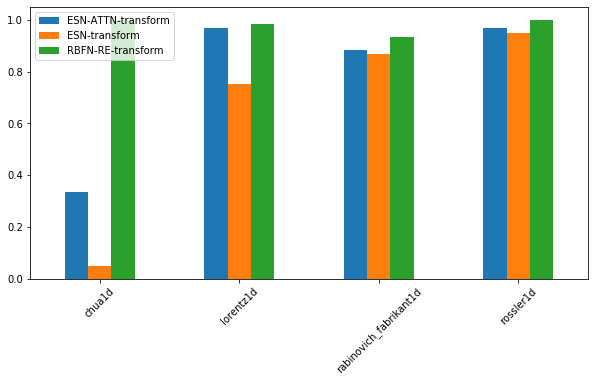

In [129]:
model_names = [
    'ESN-ATTN-transform',
    'ESN-transform', 
#     'ESN-echostate',
#     'ESN-ATTN-echostate',
#     'VAR', 
    'RBFN-RE-transform',
#     'RBFN-RE-echostate'
]



average = pd.DataFrame()
for i in range(50):
    result_file = path + '/result_' +str(i) + '.csv' 
    df = pd.read_csv(result_file, index_col = 'datetime')
    df.index = pd.DatetimeIndex(df.index)

    result = df[
                df['system_name'].isin(system_names) & 
                df['model_name'].isin(model_names) &
                df['nz'].isin([100])
            ]

    average = average.append(result,ignore_index=True)


result = pd.pivot_table(average, 
                        index=['system_name'], 
                        columns=['model_name'], 
                        values=['valid'], 
                        aggfunc=lambda x: np.sum(x)/len(x),
                       )
print(result)

result.plot.bar(figsize = (10,5))
plt.legend(labels=[i[1] for i in result.columns], loc='upper left')
plt.xticks(rotation = 45)
plt.xlabel('')
plt.ylabel('')
plt.show()

['ESN-ATTN-echostate',
 'ESN-ATTN-transform',
 'ESN-echostate',
 'ESN-transform',
 'RBFN-RE-echostate',
 'RBFN-RE-transform',
 'VAR']

ValueError: Index datetime invalid